In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from UnarySim.sw.kernel.shiftreg import ShiftReg
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.kernel.add import UnaryAdd, GainesAdd
from UnarySim.sw.kernel.abs import UnaryAbs
from UnarySim.sw.metric.metric import ProgressiveError, Stability, NormStability
import math
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
import math
import numpy as np

In [3]:
class GainesEdgeDetect(torch.nn.Module):
    """
    this module is a unary based implementation of Robert's cross operator. Reference to "Using Stochastic Computing to Implement DigitalImage Processing Algorithms."
    """
    def __init__(self,
                 rng="Sobol",
                 rng_width=1,
                 rng_dim=4,
                 depth=4,
                 scaled=True,
                 interleave=True,
                 rtype=torch.float,
                 btype=torch.float,
                 stype=torch.float):
        super(GainesEdgeDetect, self).__init__()

        self.bitwidth = rng_width
        self.rng_dim = rng_dim
        self.rng = "Sobol"
        self.rtype = rtype
        self.btype = btype
        self.stype = stype

        self.Gx_sub = GainesAdd(mode="bipolar", 
                 scaled=scaled, 
                 acc_dim=0, 
                 rng=self.rng, 
                 rng_dim=self.rng_dim, 
                 rng_width=1, 
                 rtype=self.rtype, 
                 stype=self.stype)

        self.Gy_sub = GainesAdd(mode="bipolar", 
                 scaled=scaled, 
                 acc_dim=0, 
                 rng=self.rng, 
                 rng_dim=self.rng_dim+4, 
                 rng_width=1, 
                 rtype=self.rtype, 
                 stype=self.stype)

        self.G_add = GainesAdd(mode="bipolar", 
                scaled=scaled, 
                acc_dim=0, 
                rng=self.rng, 
                rng_dim=self.rng_dim+8, 
                rng_width=1, 
                rtype=self.rtype, 
                stype=self.stype)

        self.GxAbs = UnaryAbs(depth=depth, shiftreg=False, interleave=interleave, stype=self.stype, btype=self.btype)
        self.GyAbs = UnaryAbs(depth=depth, shiftreg=False, interleave=interleave, stype=self.stype, btype=self.btype)

        self.Gx=0
        self.Gy=0
        self.Gx_abs=0
        self.Gy_abs=0

        
    def forward(self, inp_Pr_i_j, inp_Pr_i1_j1, inp_Pr_i1_j, inp_Pr_i_j1):

        Pr_i_j = inp_Pr_i_j.type(self.stype)
        Pr_i1_j1 = inp_Pr_i1_j1.type(self.stype)
        Pr_i1_j = inp_Pr_i1_j.type(self.stype)
        Pr_i_j1 = inp_Pr_i_j1.type(self.stype)

        Gx_inp = torch.stack([Pr_i_j,1-Pr_i1_j1],0)
        Gy_inp = torch.stack([Pr_i_j1,1-Pr_i1_j],0)

        self.Gx = self.Gx_sub(Gx_inp)
        self.Gy = self.Gy_sub(Gy_inp)

        self.Gx_abs = self.GxAbs(self.Gx)[1]
        self.Gy_abs = self.GyAbs(self.Gy)[1]

        G_inp = torch.stack([self.Gx_abs,self.Gy_abs],0)

        Ps_i_j = self.G_add(G_inp)

        output = Ps_i_j

        return output.type(self.stype)


In [4]:
class UnaryEdgeDetect(torch.nn.Module):
    """
    this module is a unary based implementation of Robert's cross operator. Reference to "Using Stochastic Computing to Implement DigitalImage Processing Algorithms."
    """
    def __init__(self,  
                 depth=4,
                 scaled=True,
                 interleave=True,
                 rtype=torch.float,
                 btype=torch.float, 
                 stype=torch.float):
        super(UnaryEdgeDetect, self).__init__()

        self.rtype = rtype
        self.btype = btype
        self.stype = stype

        self.Gx_sub = UnaryAdd(mode="bipolar", 
                 scaled=scaled, 
                 acc_dim=0, 
                 stype=self.stype)

        self.Gy_sub = UnaryAdd(mode="bipolar", 
                 scaled=scaled, 
                 acc_dim=0, 
                 stype=self.stype)

        self.G_add = UnaryAdd(mode="bipolar", 
                scaled=scaled, 
                acc_dim=0, 
                stype=self.stype)

        self.GxAbs = UnaryAbs(depth=depth, shiftreg=False, interleave=interleave, stype=self.stype, btype=self.btype)
        self.GyAbs = UnaryAbs(depth=depth, shiftreg=False, interleave=interleave, stype=self.stype, btype=self.btype)

        self.Gx=0
        self.Gy=0
        self.Gx_abs=0
        self.Gy_abs=0

        
    def forward(self, inp_Pr_i_j, inp_Pr_i1_j1, inp_Pr_i1_j, inp_Pr_i_j1):

        Pr_i_j = inp_Pr_i_j.type(self.stype)
        Pr_i1_j1 = inp_Pr_i1_j1.type(self.stype)
        Pr_i1_j = inp_Pr_i1_j.type(self.stype)
        Pr_i_j1 = inp_Pr_i_j1.type(self.stype)

        Gx_inp = torch.stack([Pr_i_j,1-Pr_i1_j1],0)
        Gy_inp = torch.stack([Pr_i_j1,1-Pr_i1_j],0)

        self.Gx = self.Gx_sub(Gx_inp)
        self.Gy = self.Gy_sub(Gy_inp)

        self.Gx_abs = self.GxAbs(self.Gx)[1]
        self.Gy_abs = self.GyAbs(self.Gy)[1]

        G_inp = torch.stack([self.Gx_abs,self.Gy_abs],0)

        Ps_i_j = self.G_add(G_inp)

        output = Ps_i_j

        return output.type(self.stype)


In [5]:
def detect(
    Gaines = True,
    ns = True,
    bitwidth = 8,
    mode = "bipolar",
    rng = "Sobol",
    depth = 8,
    scaled = True,
    interleave = True,
    threshold = 0.1
):
    
    btype = torch.float
    rtype = torch.float
    stype = torch.float

    if ns is True:
        device = "cpu"
    else:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # source image data
    im = Image.open("cameraman.png"); im = im.convert("L") 
    data = im.getdata(); data = np.matrix(data); data = np.reshape(data,(256,256))

    # input generation, divide the whole image into four overlapping 255*255 windows
    inp_Pr_i_j = torch.tensor(data[0:255,0:255]).type(torch.float).to(device)
    inp_Pr_i1_j1 = torch.tensor(data[1:256,1:256]).type(torch.float).to(device)
    inp_Pr_i1_j = torch.tensor(data[1:256,0:255]).type(torch.float).to(device)
    inp_Pr_i_j1 = torch.tensor(data[0:255,1:256]).type(torch.float).to(device)

    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # binary detection
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Calculation in parellel, save data in B_output, and Bdata is for image plotting
    Gx = inp_Pr_i_j - inp_Pr_i1_j1
    Gy = inp_Pr_i_j1 - inp_Pr_i1_j
    Gx_abs = torch.abs(Gx)
    Gy_abs = torch.abs(Gy)
    B_output = (Gx_abs + Gy_abs)

    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # unary detection
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    if scaled is True:
        input_scale = 255; layer1_scale = 255*2; layer2_scale = 255*2; output_scale = 255*4;
    else:
        input_scale = 255; layer1_scale = 255;   layer2_scale = 255;   output_scale = 255;

    input = torch.stack([(inp_Pr_i_j/input_scale), (inp_Pr_i1_j1/input_scale), (inp_Pr_i1_j/input_scale),(inp_Pr_i_j1/input_scale)],0)

    inputSRC = SourceGen(prob=input, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)
    inputRNG = RNG(bitwidth=bitwidth, dim=1, rng=rng, rtype=rtype)().to(device)
    inputBS = BSGen(source=inputSRC, rng_seq=inputRNG, stype=stype).to(device)

    if Gaines is True:
        Ued = GainesEdgeDetect(rng=rng, rng_width=1, rng_dim=4, depth=depth,scaled=scaled, interleave=interleave, rtype=rtype, btype=btype, stype=stype).to(device)
    else:
        Ued = UnaryEdgeDetect(depth=depth, scaled=scaled, interleave=interleave, rtype=rtype, btype=btype, stype=stype).to(device)

    inputPE  = ProgressiveError(in_value=input,                 mode=mode).to(device)
    outputPE = ProgressiveError(in_value=B_output/output_scale, mode=mode).to(device)

    if ns is True:
        inijNs   = NormStability(in_value=inp_Pr_i_j/input_scale,   mode="bipolar", threshold=threshold).to(device)
        ini1j1Ns = NormStability(in_value=inp_Pr_i1_j1/input_scale, mode="bipolar", threshold=threshold).to(device)
        ini1jNs  = NormStability(in_value=inp_Pr_i1_j/input_scale,  mode="bipolar", threshold=threshold).to(device)
        inij1Ns  = NormStability(in_value=inp_Pr_i_j1/input_scale,  mode="bipolar", threshold=threshold).to(device)
        GxNS     = NormStability(in_value=Gx/layer1_scale,          mode="bipolar", threshold=threshold).to(device)
        GyNS     = NormStability(in_value=Gy/layer1_scale,          mode="bipolar", threshold=threshold).to(device)
        GxabsNS  = NormStability(in_value=Gx_abs/layer2_scale,      mode="bipolar", threshold=threshold).to(device)
        GyabsNS  = NormStability(in_value=Gy_abs/layer2_scale,      mode="bipolar", threshold=threshold).to(device)
        GNS      = NormStability(in_value=B_output/output_scale,    mode="bipolar", threshold=threshold).to(device)
    else:
        inijNs   = Stability(in_value=inp_Pr_i_j/input_scale,   mode="bipolar", threshold=threshold).to(device)
        ini1j1Ns = Stability(in_value=inp_Pr_i1_j1/input_scale, mode="bipolar", threshold=threshold).to(device)
        ini1jNs  = Stability(in_value=inp_Pr_i1_j/input_scale,  mode="bipolar", threshold=threshold).to(device)
        inij1Ns  = Stability(in_value=inp_Pr_i_j1/input_scale,  mode="bipolar", threshold=threshold).to(device)
        GxNS     = Stability(in_value=Gx/layer1_scale,          mode="bipolar", threshold=threshold).to(device)
        GyNS     = Stability(in_value=Gy/layer1_scale,          mode="bipolar", threshold=threshold).to(device)
        GxabsNS  = Stability(in_value=Gx_abs/layer2_scale,      mode="bipolar", threshold=threshold).to(device)
        GyabsNS  = Stability(in_value=Gy_abs/layer2_scale,      mode="bipolar", threshold=threshold).to(device)
        GNS      = Stability(in_value=B_output/output_scale,    mode="bipolar", threshold=threshold).to(device)

    # result_pe_cycle = []
    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            input_bs = inputBS(torch.tensor([i]))
            inputPE.Monitor(input_bs)

            inijNs.Monitor(input_bs[0])
            ini1j1Ns.Monitor(input_bs[1])
            ini1jNs.Monitor(input_bs[2])
            inij1Ns.Monitor(input_bs[3])

            output_bs = Ued(input_bs[0], input_bs[1], input_bs[2], input_bs[3])

            GxNS.Monitor(Ued.Gx)
            GyNS.Monitor(Ued.Gy)
            GxabsNS.Monitor(Ued.Gx_abs)
            GyabsNS.Monitor(Ued.Gy_abs)

            GNS.Monitor(output_bs)
            outputPE.Monitor(output_bs)

            # Udata, result_pe = outputPE()
            # result_pe = result_pe.cpu().numpy()
            # result_pe_cycle.append(np.mean(np.abs(result_pe)))

        print("--- %s seconds ---" % (time.time() - start_time))
        input_Pij_ns = inijNs()
        input_Pi1j1_ns = ini1j1Ns()
        input_Pi1j_ns = ini1jNs()
        input_Pij1_ns = inij1Ns()
        input_ns = (input_Pij_ns + input_Pi1j1_ns + input_Pi1j_ns + input_Pij1_ns)/4

        Gx_ns = GxNS()
        Gy_ns = GyNS()
        after_adder1_ns = (Gx_ns + Gy_ns)/2

        Gx_abs_ns = GxabsNS()
        Gy_abs_ns = GyabsNS()
        after_abs_ns = (Gx_abs_ns + Gy_abs_ns)/2

        output_ns = GNS()

        input_ns = input_ns.cpu().numpy()
        after_adder1_ns = after_adder1_ns.cpu().numpy()
        after_abs_ns = after_abs_ns.cpu().numpy()
        output_ns = output_ns.cpu().numpy()

        print("I  NS: avg:%1.4f, max:%1.4f, min:%1.4f" % (np.mean(input_ns),        np.max(input_ns),        np.min(input_ns)))
        print("L1 NS: avg:%1.4f, max:%1.4f, min:%1.4f" % (np.mean(after_adder1_ns), np.max(after_adder1_ns), np.min(after_adder1_ns)))
        print("L2 NS: avg:%1.4f, max:%1.4f, min:%1.4f" % (np.mean(after_abs_ns),    np.max(after_abs_ns),    np.min(after_abs_ns)))
        print("O  NS: avg:%1.4f, max:%1.4f, min:%1.4f" % (np.mean(output_ns),       np.max(output_ns),       np.min(output_ns)))

    Udata, result_pe = outputPE()
    result_pe = result_pe.cpu().numpy()
    print("RMSE:%1.4f, MAE :%1.4f, bias:%1.4f, max :%1.4f, min :%1.4f" % (np.sqrt(np.mean(result_pe**2)), np.mean(np.abs(result_pe)), np.mean(result_pe), np.max(result_pe), np.min(result_pe)))

    plt.figure(); plt.imshow(im, cmap='gray');      plt.title("Original image")
    Bdata = (B_output).cpu().numpy();               image_b = Image.fromarray(Bdata)
    plt.figure(); plt.imshow(image_b, cmap='gray'); plt.title("Binary outcome")
    Udata = (Udata*output_scale).cpu().numpy();     image_u = Image.fromarray(Udata)
    plt.figure(); plt.imshow(image_u, cmap='gray'); plt.title("Unary outcome")
    
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # now use the calculated ns to early stop
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    stop_cycle = math.ceil((1-np.mean(output_ns)) * (2**bitwidth))
    print("\n\nEarly termination at cycle %d" % (stop_cycle))
    
    inputSRC = SourceGen(prob=input, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)
    inputRNG = RNG(bitwidth=bitwidth, dim=1, rng=rng, rtype=rtype)().to(device)
    inputBS = BSGen(source=inputSRC, rng_seq=inputRNG, stype=stype).to(device)

    if Gaines is True:
        Ued = GainesEdgeDetect(rng=rng, rng_width=1, rng_dim=4, rtype=rtype, btype=btype, stype=stype).to(device)
    else:
        Ued = UnaryEdgeDetect(depth=depth, scaled=scaled, interleave=interleave, rtype=rtype, btype=btype, stype=stype).to(device)

    inputPE  = ProgressiveError(in_value=input,                 mode=mode).to(device)
    outputPE = ProgressiveError(in_value=B_output/output_scale, mode=mode).to(device)

    # result_pe_cycle = []
    with torch.no_grad():
        start_time = time.time()
        for i in range(stop_cycle):
            input_bs = inputBS(torch.tensor([i]))
            inputPE.Monitor(input_bs)
            output_bs = Ued(input_bs[0], input_bs[1], input_bs[2], input_bs[3])
            outputPE.Monitor(output_bs)

    Udata, result_pe = outputPE()
    result_pe = result_pe.cpu().numpy()
    print("RMSE:%1.4f, MAE :%1.4f, bias:%1.4f, max :%1.4f, min :%1.4f" % (np.sqrt(np.mean(result_pe**2)), np.mean(np.abs(result_pe)), np.mean(result_pe), np.max(result_pe), np.min(result_pe)))

    Udata = (Udata*output_scale).cpu().numpy();     image_u = Image.fromarray(Udata)
    plt.figure(); plt.imshow(image_u, cmap='gray'); plt.title("Early Teminated Unary outcome")
    

--- 5.8670008182525635 seconds ---
I  NS: avg:0.9651, max:1.0000, min:0.9299
L1 NS: avg:0.9508, max:0.9844, min:0.8994
L2 NS: avg:0.2003, max:0.9814, min:0.0000
O  NS: avg:0.1819, max:0.9814, min:0.0000
RMSE:0.2046, MAE :0.1545, bias:-0.1513, max :0.1701, min :-0.6309


Early termination at cycle 838
RMSE:0.2209, MAE :0.1704, bias:-0.1674, max :0.1670, min :-0.6336


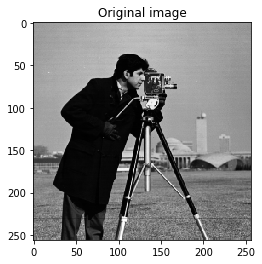

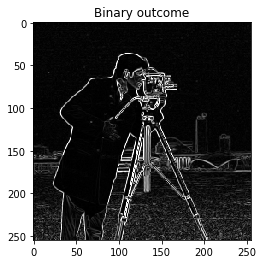

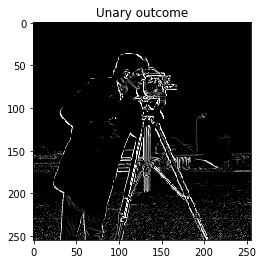

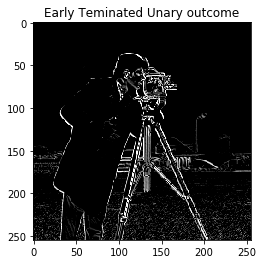

In [6]:
detect(Gaines = True, ns = True, bitwidth = 10, mode = "bipolar", rng = "Sobol", depth = 4, scaled = True, interleave = True, threshold = 0.05)

--- 5.944004058837891 seconds ---
I  NS: avg:0.9876, max:1.0000, min:0.9746
L1 NS: avg:0.9780, max:0.9932, min:0.9502
L2 NS: avg:0.3229, max:0.9912, min:0.0000
O  NS: avg:0.3147, max:0.9912, min:0.0000
RMSE:0.2046, MAE :0.1545, bias:-0.1513, max :0.1701, min :-0.6309


Early termination at cycle 702
RMSE:0.2346, MAE :0.1849, bias:-0.1822, max :0.1646, min :-0.6823


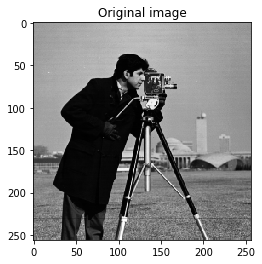

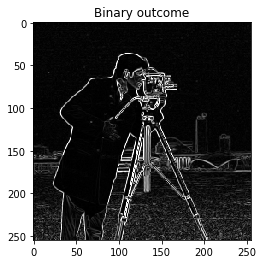

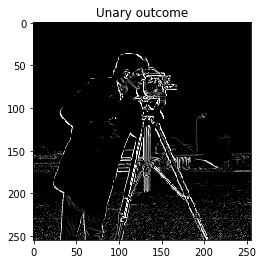

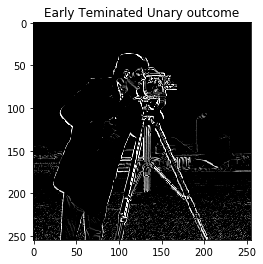

In [7]:
detect(Gaines = True, ns = True, bitwidth = 10, mode = "bipolar", rng = "Sobol", depth = 4, scaled = True, interleave = True, threshold = 0.1)

--- 6.1570024490356445 seconds ---
I  NS: avg:0.9651, max:1.0000, min:0.9299
L1 NS: avg:0.9736, max:0.9912, min:0.9131
L2 NS: avg:0.9764, max:0.9912, min:0.9131
O  NS: avg:0.9670, max:1.0000, min:0.8232
RMSE:0.0006, MAE :0.0003, bias:-0.0001, max :0.0039, min :-0.0039


Early termination at cycle 34
RMSE:0.0340, MAE :0.0255, bias:-0.0007, max :0.1569, min :-0.1294


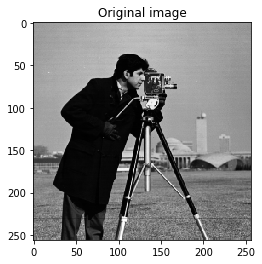

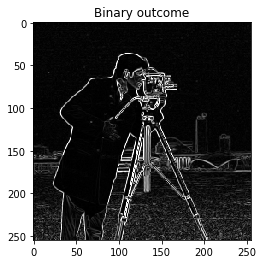

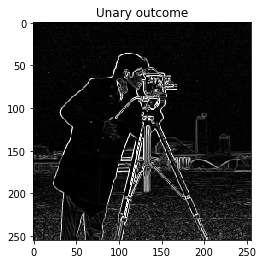

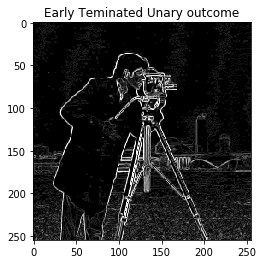

In [8]:
detect(Gaines = False, ns = True, bitwidth = 10, mode = "bipolar", rng = "Sobol", depth = 4, scaled = False, interleave = False, threshold = 0.05)

--- 6.245000123977661 seconds ---
I  NS: avg:0.9876, max:1.0000, min:0.9746
L1 NS: avg:0.9889, max:0.9951, min:0.9624
L2 NS: avg:0.9900, max:0.9951, min:0.9629
O  NS: avg:0.9869, max:1.0000, min:0.9268
RMSE:0.0006, MAE :0.0003, bias:-0.0001, max :0.0039, min :-0.0039


Early termination at cycle 14
RMSE:0.0646, MAE :0.0429, bias:-0.0022, max :0.3238, min :-0.3882


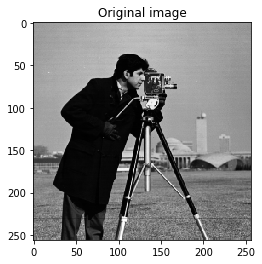

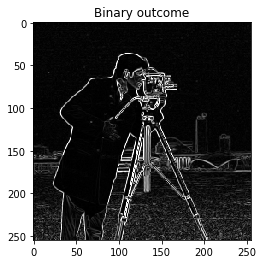

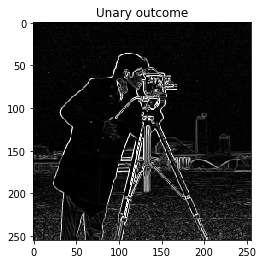

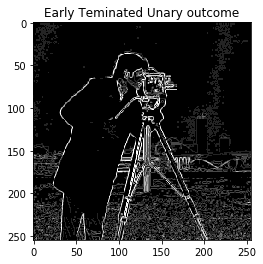

In [9]:
detect(Gaines = False, ns = True, bitwidth = 10, mode = "bipolar", rng = "Sobol", depth = 4, scaled = False, interleave = False, threshold = 0.1)